## Assignment: Image recognition
- Alumno 1:
- Alumno 2:
- Alumno 3:

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/2DDPE2zHw5dbM3G](https://drive.upm.es/s/2DDPE2zHw5dbM3G)

In [41]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import requests
import zipfile

url = 'https://drive.upm.es/s/2DDPE2zHw5dbM3G/download'
zip_name = 'dataset.zip'

r = requests.get(url, stream=True)
with open(zip_name, 'wb') as f:
    for chunk in r.iter_content(chunk_size=1024):
        f.write(chunk)

if os.path.getsize(zip_name) < 10000:
    print(f"ERREUR : Le fichier {zip_name} est trop petit. Le lien est invalide ou nécessite une connexion.")
else:
    with zipfile.ZipFile(zip_name, 'r') as z:
        z.extractall(".") 

    target_file = 'xview_ann_train.json'
    found_path = None
    
    for root, dirs, files in os.walk("."):
        if target_file in files:
            found_path = os.path.join(root, target_file)
            break
    
    if found_path:
        print(f"SUCCÈS : Fichier trouvé à : {found_path}")
        
        import json
        json_file = found_path 
        
        with open(json_file) as ifs:
            json_data = json.load(ifs)
        print("Base de données chargée avec succès !")
        
    else:
        print(f"ERREUR : {target_file} reste introuvable après extraction.")

SUCCÈS : Fichier trouvé à : ./xview_recognition/xview_ann_train.json
Base de données chargée avec succès !


In [42]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[]


In [43]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [44]:
categories = {0: 'Cargo plane', 1: 'Small car', 2: 'Bus', 3: 'Truck', 4: 'Motorboat', 5: 'Fishing vessel', 6: 'Dump truck', 7: 'Excavator', 8: 'Building', 9: 'Helipad', 10: 'Storage tank', 11: 'Shipping container', 12: 'Pylon'}

In [45]:
!pip install rasterio

In [46]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open('./xview_recognition/'+filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [47]:
import json

# Load database
json_file = './xview_recognition/xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [48]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)
labels = [img.objects[0].category for img in anns]

{'Cargo plane': 635, 'Small car': 3324, 'Bus': 1768, 'Truck': 2210, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 3594, 'Helipad': 111, 'Storage tank': 1469, 'Shipping container': 1523, 'Pylon': 312}


In [49]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True, stratify=labels)
print('Number of training images: ' + str(len(anns_train)))
print('Number of validation images: ' + str(len(anns_valid)))

Number of training images: 16871
Number of validation images: 1875


In [50]:
# Load architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Normalization
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras.optimizers import Nadam 
import tensorflow as tf

#norm_layer = Normalization()

model = Sequential()
model.add(Input(shape=(56, 56, 3)))
#model.add(norm_layer)
model.add(Flatten())

# Layer 1
model.add(Dense(1024, kernel_initializer='he_normal')) 
#model.add(BatchNormalization())
model.add(Activation('swish')) 
#model.add(Dropout(0.4)) 

# Layer 2
model.add(Dense(512, kernel_initializer='he_normal')) 
#model.add(BatchNormalization())
model.add(Activation('swish')) 
#model.add(Dropout(0.4)) 

# Layer 3
model.add(Dense(256, kernel_initializer='he_normal')) 
#model.add(BatchNormalization())
model.add(Activation('swish')) 
#model.add(Dropout(0.4)) 

# Output
model.add(Dense(len(categories)))
model.add(Activation('softmax'))

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001, 
    decay_steps=40 * (len(anns_train) // 32)
)

model.compile(
    optimizer=Nadam(learning_rate=lr_schedule, weight_decay=1e-4),
    loss=CategoricalFocalCrossentropy(alpha=0.25, gamma=2.0), 
    metrics=['accuracy']
)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 9408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │     9,634,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 13)             │         3,341 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 13)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,294,285 (39.27 MB)

 Trainable params: 10,294,285 (39.27 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
#from tensorflow.keras.optimizers import Adam
#
## Learning rate is changed to 0.001
#opt = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0)
#model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
#reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, early_stop, terminate]

In [53]:
def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                img = load_geoimage(filename)
                # Convertir en tenseur Tensorflow pour le traitement
                img_tensor = tf.convert_to_tensor(img)
                # Convertir en float32 et normaliser entre 0 et 1
                img_tensor = tf.image.convert_image_dtype(img_tensor, tf.float32)
                # Redimensionnement via bicubic (+ précis)
                img_resized = tf.image.resize(img_tensor, [56, 56], method='bicubic')
                # On repasse en Numpy pour construire le batch
                images.append(img_resized.numpy())                
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [54]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 32 # change to 32 to stabilize the gradients
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

In [55]:
import math
import numpy as np

print('Training model')
epochs = 50 # model still improving after 20 epochs -> stabilization
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
h = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks, verbose=1)
# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model
Epoch 1/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.3037 - loss: 0.5709
Epoch 1: val_accuracy improved from -inf to 0.44213, saving model to model.keras
528/528 ━━━━━━━━━━━━━━━━━━━━ 128s 237ms/step - accuracy: 0.3038 - loss: 0.5705 - val_accuracy: 0.4421 - val_loss: 0.2780
Epoch 2/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.4503 - loss: 0.2712
Epoch 2: val_accuracy did not improve from 0.44213
528/528 ━━━━━━━━━━━━━━━━━━━━ 124s 235ms/step - accuracy: 0.4503 - loss: 0.2712 - val_accuracy: 0.4368 - val_loss: 0.2937
Epoch 3/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.4830 - loss: 0.2472
Epoch 3: val_accuracy improved from 0.44213 to 0.50080, saving model to model.keras
528/528 ━━━━━━━━━━━━━━━━━━━━ 125s 236ms/step - accuracy: 0.4830 - loss: 0.2472 - val_accuracy: 0.5008 - val_loss: 0.2467
Epoch 4/50
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.5149 - loss: 0.2263
Epoch 4: val_accuracy did not improve from 0.50080
528

#### Validation
Compute validation metrics.

In [56]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.colormaps['Blues'])
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show()

In [57]:
import numpy as np

model.load_weights('model.keras')
y_true, y_pred = [], []
for ann in anns_valid:
    # 1. Charger l'image brute (Taille d'origine : 224x224)
    image_raw = load_geoimage(ann.filename)
    # Conversion en Tensor pour utiliser les outils Tensorflow
    image_tensor = tf.convert_to_tensor(image_raw)
    image_tensor = tf.image.convert_image_dtype(image_tensor, tf.float32)
    image_resized = tf.image.resize(image_tensor, [56, 56], method='bicubic')
    warped_image = np.expand_dims(image_resized.numpy(), 0)

    for obj_pred in ann.objects:
        # Prédiction sur l'image correctement redimensionnée
        predictions = model.predict(warped_image, verbose=0)
        
        # Récupération du résultat
        pred_category = list(categories.values())[np.argmax(predictions)]
        
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

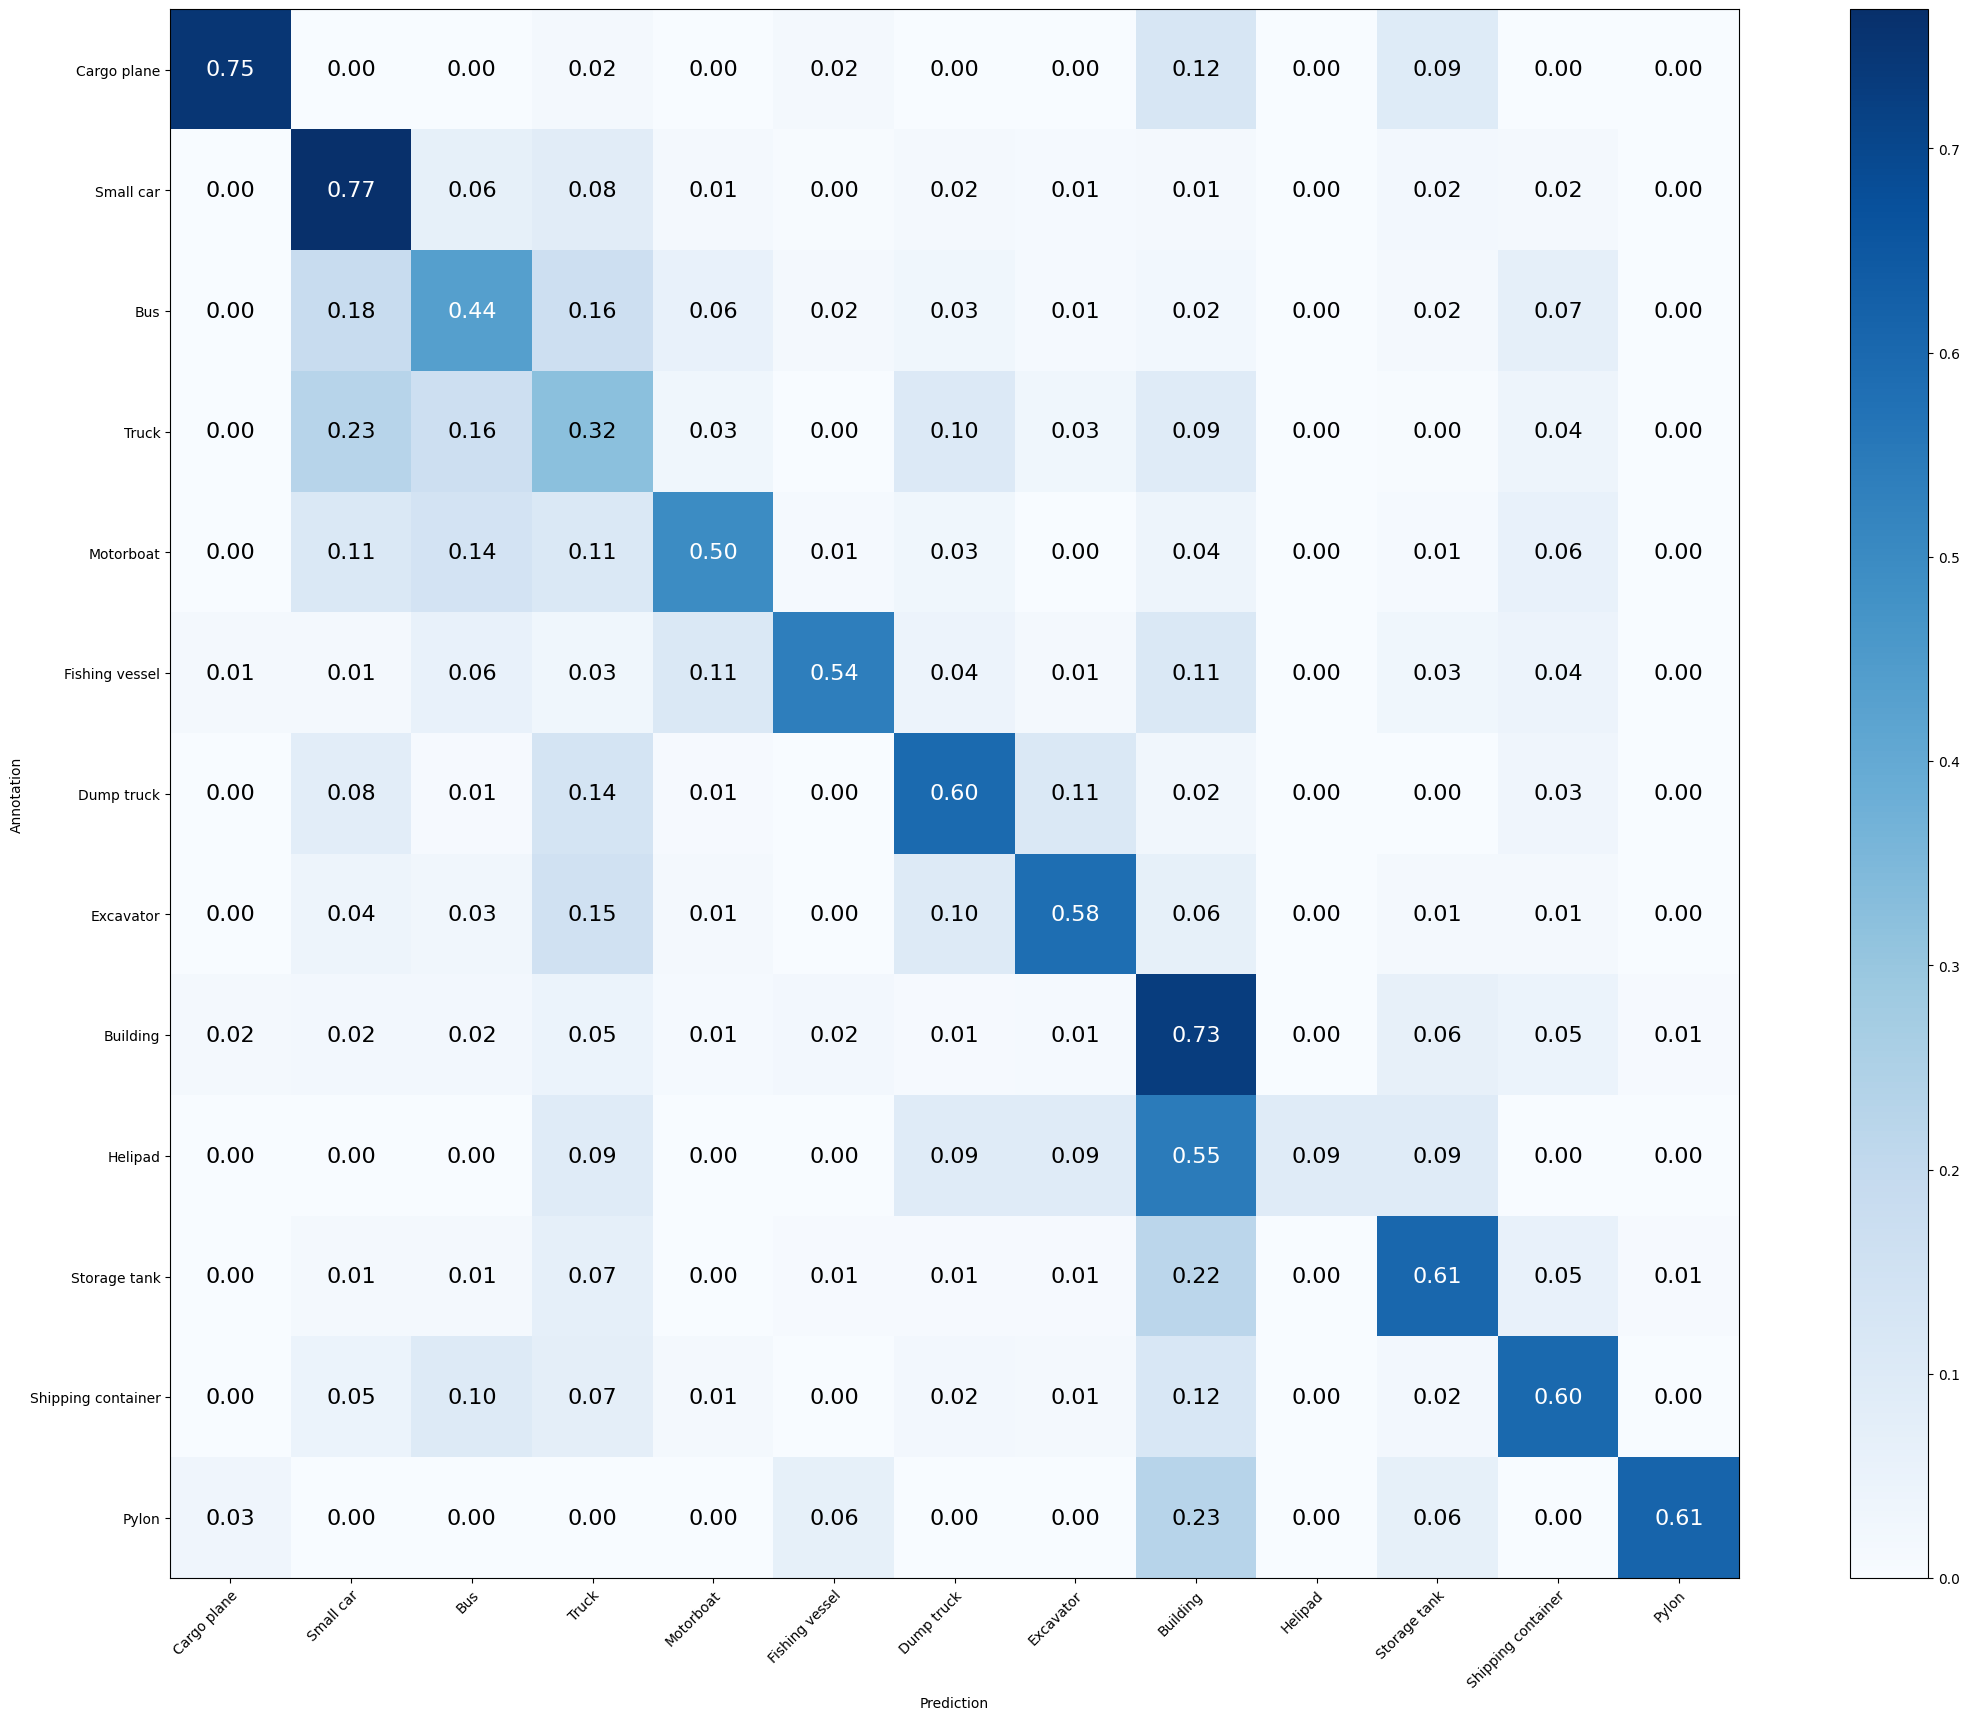

In [58]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [59]:
import numpy as np

# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 59.893%
Mean Recall: 54.761%
Mean Precision: 61.475%
> Cargo plane: Recall: 75.000% Precision: 85.714% Specificity: 99.558% Dice: 80.000%
> Small car: Recall: 76.807% Precision: 67.282% Specificity: 91.964% Dice: 71.730%
> Bus: Recall: 43.503% Precision: 42.778% Specificity: 93.934% Dice: 43.137%
> Truck: Recall: 32.127% Precision: 33.649% Specificity: 91.536% Dice: 32.870%
> Motorboat: Recall: 49.533% Precision: 59.551% Specificity: 97.964% Dice: 54.082%
> Fishing vessel: Recall: 53.521% Precision: 70.370% Specificity: 99.113% Dice: 60.800%
> Dump truck: Recall: 59.677% Precision: 57.364% Specificity: 96.859% Dice: 58.498%
> Excavator: Recall: 58.228% Precision: 57.500% Specificity: 98.107% Dice: 57.862%
> Building: Recall: 72.702% Precision: 68.684% Specificity: 92.150% Dice: 70.636%
> Helipad: Recall: 9.091% Precision: 50.000% Specificity: 99.946% Dice: 15.385%
> Storage tank: Recall: 60.544% Precision: 64.964% Specificity: 97.222% Dice: 62.676%
> Shipping container: 

#### Testing
Try to improve the results provided in the competition.

In [60]:
import os
import numpy as np

anns = []
root_dir = './xview_recognition/'
test_dir = os.path.join(root_dir, 'xview_test')
for (dirpath, dirnames, filenames) in os.walk(test_dir):
    for filename in filenames:
        rel_dir = os.path.relpath(dirpath, root_dir)
        clean_filename = os.path.join(rel_dir, filename)
        image = GenericImage(clean_filename)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = os.path.basename(dirpath)
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

Number of testing images: 2365


In [62]:
import numpy as np
import tensorflow as tf

model.load_weights('model.keras')
predictions_data = {"images": {}, "annotations": {}}

ann_id = 0

for idx, ann in enumerate(anns):
    image_data = {
        "image_id": ann.filename.split('/')[-1], 
        "filename": ann.filename, 
        "width": int(ann.tile[2]), 
        "height": int(ann.tile[3])
    }
    predictions_data["images"][idx] = image_data
    
    # Charger l'image brute
    image_raw = load_geoimage(ann.filename)
    image_tensor = tf.convert_to_tensor(image_raw)
    image_tensor = tf.image.convert_image_dtype(image_tensor, tf.float32)
    image_resized = tf.image.resize(image_tensor, [56, 56], method='bicubic')
    warped_image = np.expand_dims(image_resized.numpy(), 0)

    for obj_pred in ann.objects:
        predictions = model.predict(warped_image, verbose=0)
        pred_category = list(categories.values())[np.argmax(predictions)]
        annotation_data = {
            "image_id": ann.filename.split('/')[-1], 
            "category_id": pred_category, 
            "bbox": [int(x) for x in obj_pred.bb]
        }
        predictions_data["annotations"][ann_id] = annotation_data
        ann_id += 1

Génération des résultats...
Terminé. 2365 annotations générées.


In [68]:
import json
with open('prediction.json', 'w') as f:
    json.dump(predictions_data, f)